In [1]:
import pandas as pd
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import skimage
from skimage.transform import resize


In [2]:
data=pd.read_csv("./fer2013/fer2013.csv")

In [3]:
data.columns

Index([u'emotion', u'pixels', u'Usage'], dtype='object')

In [4]:
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [25]:
a=np.array(data['pixels'].iloc[0].split(" "))

In [12]:
np.unique(data['Usage'])

array(['PrivateTest', 'PublicTest', 'Training'], dtype=object)

In [15]:
unique, counts = np.unique(data['Usage'], return_counts=True)
print(list(zip(unique, counts)))

[('PrivateTest', 3589), ('PublicTest', 3589), ('Training', 28709)]


In [16]:
len(data)

35887

In [18]:
data['Usage'].iloc[0]

'Training'

In [27]:
def read_data(data):
    x_train=[]
    y_train=[]
    x_test=[]
    y_test=[]
    x_val=[]
    y_val=[]
    for i in range(len(data)):
        a=np.array(data['pixels'].iloc[i].split(" "))
        a= [float(x) for x in a]
        a=np.reshape(a,(48,48,1))
        
        if(data['Usage'].iloc[i]=='Training'):
            x_train.append(a)
            y_train.append(data['emotion'].iloc[i])
        elif(data['Usage'].iloc[i]=='PublicTest'):
            x_val.append(a)
            y_val.append(data['emotion'].iloc[i])
        elif(data['Usage'].iloc[i]=='PrivateTest'):
            x_test.append(a)
            y_test.append(data['emotion'].iloc[i])
    return np.array(x_train),np.array(y_train),np.array(x_val),np.array(y_val),np.array(x_test),np.array(y_test)
        
    

In [28]:
x_train,y_train,x_val,y_val,x_test,y_test=read_data(data)

In [29]:
print(x_train.shape,x_val.shape,x_test.shape)

((28709, 48, 48, 1), (3589, 48, 48, 1), (3589, 48, 48, 1))


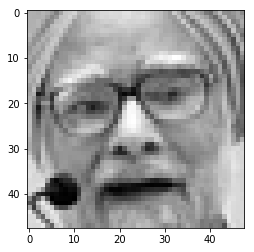

In [35]:
plt.imshow(np.reshape(x_train[1],(48,48)),cmap='gray')
plt.show()

In [50]:
from keras.models import Model
from keras.layers import Input,Dense,Dropout,Conv2D,MaxPooling2D,Flatten,Activation,BatchNormalization,GlobalAveragePooling2D
from keras.optimizers import Adam,RMSprop,SGD,Nadam,Adagrad
from keras.losses import mean_squared_error,binary_crossentropy,categorical_crossentropy
from keras.utils import np_utils
from keras.callbacks import ReduceLROnPlateau
from keras import regularizers

In [37]:
y_train=np_utils.to_categorical(y_train,7)
y_test=np_utils.to_categorical(y_test,7)
y_val=np_utils.to_categorical(y_val,7)

In [83]:
def make_model():
    inputs=Input(shape=(48,48,1))
    l=inputs
    """l=Conv2D(filters=16,kernel_size=(3,3),strides=(1,1),padding='same')(l)
    l=BatchNormalization()(l)
    l=Activation('relu')(l)
    l=Conv2D(filters=16,kernel_size=(3,3),strides=(1,1),padding='same')(l)
    l=BatchNormalization()(l)
    l=Activation('relu')(l)
    l=MaxPooling2D(pool_size=(2,2))(l)
    """
    l=Conv2D(filters=32,kernel_size=(3,3),strides=(1,1),padding='same')(l)
    l=BatchNormalization()(l)
    l=Activation('relu')(l)
    l=Conv2D(filters=32,kernel_size=(3,3),strides=(1,1),padding='same')(l)
    l=BatchNormalization()(l)
    l=Activation('relu')(l)
    l=MaxPooling2D(pool_size=(2,2))(l)
    
    l=Dropout(0.2)(l)
    
    l=Conv2D(filters=48,kernel_size=(3,3),strides=(1,1),padding='same')(l)
    l=BatchNormalization()(l)
    l=Activation('relu')(l)
    l=Conv2D(filters=48,kernel_size=(3,3),strides=(1,1),padding='same')(l)
    l=BatchNormalization()(l)
    l=Activation('relu')(l)
    l=MaxPooling2D(pool_size=(2,2))(l)
    
    l=Dropout(0.25)(l)
    
    l=Conv2D(filters=64,kernel_size=(3,3),strides=(1,1),padding='same')(l)
    l=BatchNormalization()(l)
    l=Activation('relu')(l)
    l=Conv2D(filters=64,kernel_size=(3,3),strides=(1,1),padding='same')(l)
    l=BatchNormalization()(l)
    l=Activation('relu')(l)
    l=MaxPooling2D(pool_size=(2,2))(l)
    
    l=Conv2D(filters=128,kernel_size=(3,3),strides=(1,1),padding='same')(l)
    l=BatchNormalization()(l)
    l=Activation('relu')(l)
    l=Conv2D(filters=128,kernel_size=(3,3),strides=(1,1),padding='same')(l)
    l=BatchNormalization()(l)
    l=Activation('relu')(l)
    l=MaxPooling2D(pool_size=(2,2))(l)
    
    l=Dropout(0.25)(l)
    
    l=Conv2D(filters=196,kernel_size=(3,3),strides=(1,1),padding='same')(l)
    l=BatchNormalization()(l)
    l=Activation('relu')(l)
    l=Conv2D(filters=196,kernel_size=(3,3),strides=(1,1),padding='same')(l)
    l=BatchNormalization()(l)
    l=Activation('relu')(l)
    l=MaxPooling2D(pool_size=(2,2))(l)
    
    l=GlobalAveragePooling2D()(l)
    l=Dropout(0.4)(l)
    l=Dense(196,activation='relu')(l)
    l=Dropout(0.5)(l)
    l=Dense(128,activation='relu')(l)
    l=Dense(7,activation='softmax')(l)
    outputs=l
    return inputs,outputs

In [84]:
inputs,outputs=make_model()
model=Model(inputs=inputs,outputs=outputs)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 48, 48, 1)         0         
_________________________________________________________________
conv2d_69 (Conv2D)           (None, 48, 48, 32)        320       
_________________________________________________________________
batch_normalization_69 (Batc (None, 48, 48, 32)        128       
_________________________________________________________________
activation_69 (Activation)   (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_70 (Conv2D)           (None, 48, 48, 32)        9248      
_________________________________________________________________
batch_normalization_70 (Batc (None, 48, 48, 32)        128       
_________________________________________________________________
activation_70 (Activation)   (None, 48, 48, 32)        0         
__________

In [85]:
optim=Adam(0.00005)
#optim=SGD(1e-3)
loss=categorical_crossentropy
model.compile(optim,loss,metrics=['accuracy'])


In [86]:
history=model.fit(x_train,y_train,validation_data=(x_val,y_val),epochs=20,batch_size=256,verbose=1)

Train on 28709 samples, validate on 3589 samples
Epoch 1/20
28709/28709 [==============================] - 11s 397us/step - loss: 2.1826 - acc: 0.1800 - val_loss: 1.8539 - val_acc: 0.2494
Epoch 2/20
28709/28709 [==============================] - 8s 291us/step - loss: 1.9097 - acc: 0.2020 - val_loss: 1.8293 - val_acc: 0.2494
Epoch 3/20
28709/28709 [==============================] - 8s 293us/step - loss: 1.8662 - acc: 0.2164 - val_loss: 1.8186 - val_acc: 0.2494
Epoch 4/20
28709/28709 [==============================] - 9s 297us/step - loss: 1.8398 - acc: 0.2247 - val_loss: 1.8085 - val_acc: 0.2494
Epoch 5/20
28709/28709 [==============================] - 9s 303us/step - loss: 1.8284 - acc: 0.2305 - val_loss: 1.8050 - val_acc: 0.2494
Epoch 6/20
28709/28709 [==============================] - 9s 297us/step - loss: 1.8189 - acc: 0.2355 - val_loss: 1.8040 - val_acc: 0.2494
Epoch 7/20
28709/28709 [==============================] - 9s 300us/step - loss: 1.8115 - acc: 0.2356 - val_loss: 1.7986 - 

In [87]:
history=model.fit(x_train,y_train,validation_data=(x_val,y_val),epochs=50,batch_size=256,verbose=1)

Train on 28709 samples, validate on 3589 samples
Epoch 1/50
28709/28709 [==============================] - 9s 297us/step - loss: 1.5471 - acc: 0.3955 - val_loss: 1.6083 - val_acc: 0.3884
Epoch 2/50
28709/28709 [==============================] - 8s 294us/step - loss: 1.5323 - acc: 0.4044 - val_loss: 1.5471 - val_acc: 0.4048
Epoch 3/50
28709/28709 [==============================] - 9s 297us/step - loss: 1.5146 - acc: 0.4116 - val_loss: 1.4698 - val_acc: 0.4344
Epoch 4/50
28709/28709 [==============================] - 9s 297us/step - loss: 1.5033 - acc: 0.4145 - val_loss: 1.4973 - val_acc: 0.4274
Epoch 5/50
28709/28709 [==============================] - 9s 299us/step - loss: 1.4860 - acc: 0.4229 - val_loss: 1.4535 - val_acc: 0.4397
Epoch 6/50
28709/28709 [==============================] - 9s 302us/step - loss: 1.4762 - acc: 0.4280 - val_loss: 1.4299 - val_acc: 0.4539
Epoch 7/50
28709/28709 [==============================] - 9s 297us/step - loss: 1.4607 - acc: 0.4342 - val_loss: 1.4240 - v

In [88]:
history=model.fit(x_train,y_train,validation_data=(x_val,y_val),epochs=50,batch_size=256,verbose=1)

Train on 28709 samples, validate on 3589 samples
Epoch 1/50
28709/28709 [==============================] - 8s 289us/step - loss: 1.0842 - acc: 0.5945 - val_loss: 1.1436 - val_acc: 0.5681
Epoch 2/50
28709/28709 [==============================] - 8s 291us/step - loss: 1.0771 - acc: 0.5975 - val_loss: 1.1456 - val_acc: 0.5670
Epoch 3/50
28709/28709 [==============================] - 8s 293us/step - loss: 1.0717 - acc: 0.5994 - val_loss: 1.1307 - val_acc: 0.5715
Epoch 4/50
28709/28709 [==============================] - 8s 294us/step - loss: 1.0668 - acc: 0.5978 - val_loss: 1.1266 - val_acc: 0.5768
Epoch 5/50
28709/28709 [==============================] - 8s 293us/step - loss: 1.0612 - acc: 0.6001 - val_loss: 1.1571 - val_acc: 0.5648
Epoch 6/50
28709/28709 [==============================] - 8s 294us/step - loss: 1.0541 - acc: 0.6047 - val_loss: 1.1481 - val_acc: 0.5743
Epoch 7/50
28709/28709 [==============================] - 8s 295us/step - loss: 1.0517 - acc: 0.6081 - val_loss: 1.1387 - v

In [89]:
history=model.fit(x_train,y_train,validation_data=(x_val,y_val),epochs=50,batch_size=256,verbose=1)

Train on 28709 samples, validate on 3589 samples
Epoch 1/50
28709/28709 [==============================] - 8s 291us/step - loss: 0.8175 - acc: 0.6934 - val_loss: 1.1355 - val_acc: 0.6110
Epoch 2/50
28709/28709 [==============================] - 8s 291us/step - loss: 0.8116 - acc: 0.6982 - val_loss: 1.1280 - val_acc: 0.6069
Epoch 3/50
28709/28709 [==============================] - 8s 293us/step - loss: 0.8053 - acc: 0.7007 - val_loss: 1.1376 - val_acc: 0.6160
Epoch 4/50
28709/28709 [==============================] - 8s 294us/step - loss: 0.8035 - acc: 0.7004 - val_loss: 1.1679 - val_acc: 0.6074
Epoch 5/50
28709/28709 [==============================] - 8s 295us/step - loss: 0.8057 - acc: 0.6986 - val_loss: 1.1386 - val_acc: 0.6152
Epoch 6/50
28709/28709 [==============================] - 9s 297us/step - loss: 0.7924 - acc: 0.7058 - val_loss: 1.1457 - val_acc: 0.6160
Epoch 7/50
28709/28709 [==============================] - 9s 297us/step - loss: 0.7822 - acc: 0.7111 - val_loss: 1.1543 - v

In [90]:
history=model.fit(x_train,y_train,validation_data=(x_val,y_val),epochs=20,batch_size=256,verbose=1)

Train on 28709 samples, validate on 3589 samples
Epoch 1/20
28709/28709 [==============================] - 8s 291us/step - loss: 0.5980 - acc: 0.7810 - val_loss: 1.2564 - val_acc: 0.6194
Epoch 2/20
28709/28709 [==============================] - 8s 291us/step - loss: 0.5874 - acc: 0.7829 - val_loss: 1.3261 - val_acc: 0.6244
Epoch 3/20
28709/28709 [==============================] - 8s 292us/step - loss: 0.5885 - acc: 0.7858 - val_loss: 1.2795 - val_acc: 0.6197
Epoch 4/20
28709/28709 [==============================] - 8s 294us/step - loss: 0.5877 - acc: 0.7845 - val_loss: 1.2604 - val_acc: 0.6250
Epoch 5/20
28709/28709 [==============================] - 8s 294us/step - loss: 0.5885 - acc: 0.7851 - val_loss: 1.3156 - val_acc: 0.6222
Epoch 6/20
28709/28709 [==============================] - 9s 299us/step - loss: 0.5866 - acc: 0.7862 - val_loss: 1.2743 - val_acc: 0.6236
Epoch 7/20
28709/28709 [==============================] - 9s 297us/step - loss: 0.5657 - acc: 0.7934 - val_loss: 1.2995 - v

In [91]:
history=model.fit(x_train,y_train,validation_data=(x_val,y_val),epochs=50,batch_size=256,verbose=1)

Train on 28709 samples, validate on 3589 samples
Epoch 1/50
28709/28709 [==============================] - 8s 291us/step - loss: 0.5228 - acc: 0.8111 - val_loss: 1.3206 - val_acc: 0.6236
Epoch 2/50
28709/28709 [==============================] - 8s 292us/step - loss: 0.5180 - acc: 0.8117 - val_loss: 1.3291 - val_acc: 0.6255
Epoch 3/50
28709/28709 [==============================] - 8s 295us/step - loss: 0.5176 - acc: 0.8116 - val_loss: 1.3488 - val_acc: 0.6255
Epoch 4/50
28709/28709 [==============================] - 9s 300us/step - loss: 0.5126 - acc: 0.8144 - val_loss: 1.3765 - val_acc: 0.6205
Epoch 5/50
28709/28709 [==============================] - 9s 297us/step - loss: 0.5054 - acc: 0.8153 - val_loss: 1.3535 - val_acc: 0.6294
Epoch 6/50
28709/28709 [==============================] - 9s 304us/step - loss: 0.5002 - acc: 0.8177 - val_loss: 1.3608 - val_acc: 0.6280
Epoch 7/50
28709/28709 [==============================] - 9s 300us/step - loss: 0.5026 - acc: 0.8160 - val_loss: 1.3449 - v

In [92]:
history=model.fit(x_train,y_train,validation_data=(x_val,y_val),epochs=50,batch_size=256,verbose=1)

Train on 28709 samples, validate on 3589 samples
Epoch 1/50
28709/28709 [==============================] - 8s 290us/step - loss: 0.3717 - acc: 0.8661 - val_loss: 1.5874 - val_acc: 0.6364
Epoch 2/50
28709/28709 [==============================] - 8s 290us/step - loss: 0.3684 - acc: 0.8702 - val_loss: 1.6408 - val_acc: 0.6261
Epoch 3/50
28709/28709 [==============================] - 8s 294us/step - loss: 0.3672 - acc: 0.8674 - val_loss: 1.5728 - val_acc: 0.6275
Epoch 4/50
28709/28709 [==============================] - 8s 295us/step - loss: 0.3650 - acc: 0.8689 - val_loss: 1.5685 - val_acc: 0.6297
Epoch 5/50
28709/28709 [==============================] - 9s 304us/step - loss: 0.3645 - acc: 0.8695 - val_loss: 1.5803 - val_acc: 0.6266
Epoch 6/50
28709/28709 [==============================] - 9s 299us/step - loss: 0.3597 - acc: 0.8721 - val_loss: 1.5687 - val_acc: 0.6275
Epoch 7/50
28709/28709 [==============================] - 9s 299us/step - loss: 0.3578 - acc: 0.8726 - val_loss: 1.6159 - v

In [96]:
history=model.fit(x_train,y_train,validation_data=(x_val,y_val),epochs=50,batch_size=256,verbose=1)

Train on 28709 samples, validate on 3589 samples
Epoch 1/50
28709/28709 [==============================] - 8s 291us/step - loss: 0.2631 - acc: 0.9062 - val_loss: 1.7660 - val_acc: 0.6269
Epoch 2/50
28709/28709 [==============================] - 8s 291us/step - loss: 0.2657 - acc: 0.9075 - val_loss: 1.8055 - val_acc: 0.6278
Epoch 3/50
28709/28709 [==============================] - 8s 292us/step - loss: 0.2619 - acc: 0.9076 - val_loss: 1.7644 - val_acc: 0.6289
Epoch 4/50
28709/28709 [==============================] - 8s 293us/step - loss: 0.2671 - acc: 0.9071 - val_loss: 1.7606 - val_acc: 0.6367
Epoch 5/50
28709/28709 [==============================] - 8s 294us/step - loss: 0.2573 - acc: 0.9095 - val_loss: 1.8029 - val_acc: 0.6319
Epoch 6/50
28709/28709 [==============================] - 9s 298us/step - loss: 0.2500 - acc: 0.9123 - val_loss: 1.8660 - val_acc: 0.6339
Epoch 7/50
28709/28709 [==============================] - 9s 298us/step - loss: 0.2701 - acc: 0.9049 - val_loss: 1.8198 - v

In [97]:
y_pred=model.evaluate(x_test,y_test)
print("precision :",y_pred[1])

3589/3589 [==============================] - 1s 186us/step
('precision :', 0.6472555029588212)
